# Setup

__Import libraries used by thisnotebook.__

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


__Select computation device accordingly to what is available.__

If this machine have a gpu (cuda is available) we use it. Otherwise our fallback is the CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

__Hyperparameters__

Hyperparameters control the number of iteration, size of image, and relative ration between losses (content, style, and denoising).

Fine tuning this parameter will affect the final result of the picture.

In [ ]:
ITERATIONS = 10 # Number of iterations
IMAGE_WIDTH = 600 # 512x512 is fine for HD images
IMAGE_HEIGHT = 400
CONTENT_WEIGHT = 0.7 # Weight of the content loss
STYLE_WEIGHT = 0.05 # Weight og the style loss
TOTAL_VARIATION_WEIGHT = 10 # Weight of the total variation loss
INPUT_IMAGE = 'content' # Can be : 'noise', 'content', 'style', or a path to a file.

Thw next parameters are the heart of the algorithm, They deeply affect the result of combining style and content, because they define what IS the style and content.

To compute style and content, we use a deep neural network called VGG. Here is how VGG looks like inside.
![VGG Layers](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

Tu compute the style of an image, we run the image through VGG. Then, we look at what values flowed across the layers (named _conv1_1_, _conv1_2_, etc.) and keep some of them.

For the __content__, we usually keep the first layers. The last convolutional layer from the second block is always a good bet.

For the __style__, a mix of the first conv layers (they contain color and texture informations) and last layers (they contain complexe features like trees, shapes, eyes, etc...) gives the best results.

---


__The names of layers you can add the the following lists in order to define the style and content loss are:__
  * `conv_n` where `n` is the index of the convolutional layer from the input.
  * `relu_n` where `n` is the index of the rectified linear layer from the input.
  * `pool_n` where `n` is the index of the max pooling layer from the input.
  * `bn_n` zhere `n` is the index of the batch normalization layer from the input.
  
  
  For example, convolutional layers are indexed from `conv_1` to `conv_16`.

In [ ]:
content_layers = ['conv_1', 'conv_2', 'conv_4']

style_layers = ['relu_2', 'relu_3', 'relu_4', 'relu_7', 'relu_10', 'relu_8']


Names under which the images will be saved.

In [ ]:
content_image_path = "content.png"
style_image_path = "style.png"
output_image_path = "result.png"
combined_image_path = "combined.png"

# Image selection

### Images

We download pitctures from the web, but you can also give the path to an image stored on this machine.

Just drag and drop your file on the left menu under the tab "Files", and write the name of the file (including extension) in place of the url. :)

This is the list of URL we selectionned for you, because they looks nice.

In [ ]:
# Content images
san_francisco = '/content/drive/MyDrive/Colab Notebooks/Neural Style Transfer/original.jpg'


# Style images:

tytus_second = '/content/drive/MyDrive/Colab Notebooks/Neural Style Transfer/styles/style-1.jpg'
colorswir = "https://paintings.pinotspalette.com/colorful-swirly-sky-tv.jpg?v=10026315"


# The function wich allow us to download / open an image
def open_image(url):
  if url.startswith("http"):
    return Image.open(BytesIO(requests.get(url).content))
  else:
    return Image.open(url)


This is where you select your __Content image__ and __Style Image__.

In [ ]:
content_url = san_francisco
style_url = tytus_second

### Image loading

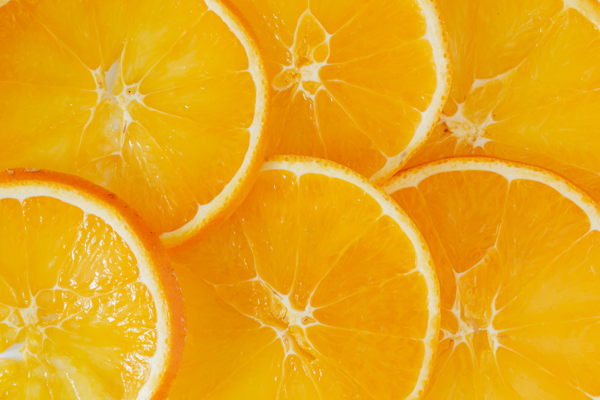

In [ ]:
#@title This is the _content_ image
content_image = open_image(content_url)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
content_image.save(content_image_path)
content_image

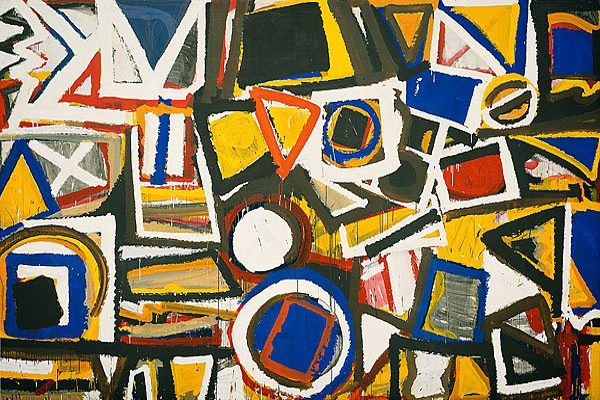

In [ ]:
#@title This is the _style_ image
style_image = open_image(style_url)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

# Build the algorithm

## Feature loss and total variation

### Feature losses

The feature loss is a loss based on which features a neural network find inside an image. We have two such losses.


The first loss is the content loss, based on what content an image contain.
It is basically like a Mean Square Error. But instead of computing the MSE on the content image's pixels and the computed image's pixels, we compute the MSE between the activation of some layers of VGG19 after running our images through it.

To compute the activation layer, we add a pytorch block named ContentLoss inside the VGG network.

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # We 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable.
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

The second loss is the style loss. Instead of looking directly to activation of the layer, we first make a computation that compute somehow  the _angle_ between the features detected by the neural network.

We compute the [gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix), which is a matrix whose coefficients are the dot product of two features vectores in the same activation layer from a single image.

We then have for each activation layer, two gram matrix (one from the style image, and one from the cotent image). We simply compute the MSE between the pairs of matrices.

The following code allow to plug a layer in VGG19 retreiving the gram matrices from each activation layer of interest.

---
__Why do I call this values _angles_?__

The Gram matrix is the matrix $G_{ij} = <v_i, v_j>$ is obtained by doing the dot product of each pair of feature vector. The dot product of two vectors $u_i$ and $v_i$ in $\mathbb{R}^3$ can be expressed as $||u_i|| .  ||v_i|| . \cos(u_i, v_i)$ where the two first terms are the length of the vectors, and the third is the cosine of the angle between this vectors.
Therefor, you can see the value of this dot product as a function of the _angle between two features_.

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()

  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

  @staticmethod
  def gram_matrix(input):
    a, b, c, d = input.size()
    # Here:
    # a is the batch size(=1)
    # b is the number of feature maps
    # (c,d) are the dimensions of a feature map

    # We reshape the activation layer into a collection of feature vectors
    features = input.view(a * b, c * d)

    # Compute the gram product
    G = torch.mm(features, features.t())

    # We 'normalize' the values of the gram matrix
    # by dividing by the norm of gram matrix filled with ones.
    return G.div((a * b * c * d) ** 0.5)

### Total Variation

The last loss is a _smoothing loss_.



This is called the total variation because it basically count the amplitude of all the variations happening in the image. Hight amplitude variation are caused by high constrats / brutal change of pixel values.

Minimizing the total variation of an image can to reducing noise (it is called [total variation denoising](https://en.wikipedia.org/wiki/Total_variation_denoising)). But you have to be carefull, because an image with a minimal total variation is a uniformly colored square. And it would be a really boring and uninteresting picture.

Too much total variation weight will lead to darker / less colorful images. But too few of it will generate very noisy images, without the "brush painting" style we are often loooking for in style transfer.

Since this is computed only from the resulting image , we just need a function to compute it.

---
_How is computed total variation ?_

Total variation is express by $\sum_{i, j} \sqrt{(x_{i+1, j}-x_{i, j})^2 + (x_{i+1, j}-x_{i, j})^2}$ where $x_{i, j}$ is the pixel at coordinates $(i, j)$. This is basically the euclidean norm of all the partial horizontal and vertical derivative of the surface given by $i, j \mapsto x_{i, j}$.
We are basically summing all the local derivative along the height map defined by the image.

This formula have the nice property to give a value which is invariant (up to an error introduced by the discrete nature of the image) by rotation.


In [ ]:
def total_variation_loss(x): # Expect a mini batch of dim NxWxH
  image_height = x.shape[1]
  image_width = x.shape[2]
  dx = x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :]
  dy = x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :]
  loss = (dx ** 2 + dy ** 2).sum() ** 0.5
  # Return loss normalized by image and batch size
  return loss / (image_width * image_height * x.shape[0])

### Normalization

We add one more block to automatically rescale and remove the mean of the images going through VGG19.

While training neural network on image dataset, all imges are their mean removed, and values are rescaled according to the standard deviation of the dataset. This is a common processing which makes the neural network convergence easier. The only implication is that once we want to use this network, we have to normalise the input image according to the coefficients used during training.

In [ ]:
# Create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # Reshape the mean and std to make them [C x 1 x 1] so that they can
    # directly broadcast to image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # Normalize img
    return (img - self.mean) / self.std


# Download and build VGG19

We now load our pretrained neural network (VGG19) for computing the losses.

In [ ]:
# Neural network used.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization mean and standard deviation.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

We now build the actual network which will be called hundreads of times by the style transfer algorithm.

We only keep the layers required to compute the feature loss, and throw everything else away. We interleave our Normalization, StyleLoss and ContentLoss layers between VGG19's layers.

In [ ]:
def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
  # We make a deep copy of vgg19 in order to not modify the original
  cnn = copy.deepcopy(cnn)

  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # This list will contain the losses computed by the network.
  content_losses = []
  style_losses = []

  # We rebuild the model as a nn sequential whose first layer is
  # our normalization layer.
  model = nn.Sequential(normalization)

  # We brows the layer of `cnn` and stack them into `model`.
  i = 0  # Incremented every time we see a conv layer.
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # Check if the layer we just added was in the content layer list.
    # If so, we just stack a Content Loss layer.
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    # Check if the layer we just added was in the style layer list.
    # If so, we just stack a Style Loss layer.
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # Now we trim off the layers after the last content and style losses
  # to keep the model as small as possible.
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

# Running the algorithm

We write a function converting PIL images to a `torch.Tensor` and apply it to our input images.

In [ ]:
def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)

content_img = image_to_tensor(content_image)
style_img = image_to_tensor(style_image)

We now declare the inverse function, converting back tensor to images.

In [ ]:
# Reconvert a tensor into PIL image
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

We now generate or load the input image from which we are going to converge.

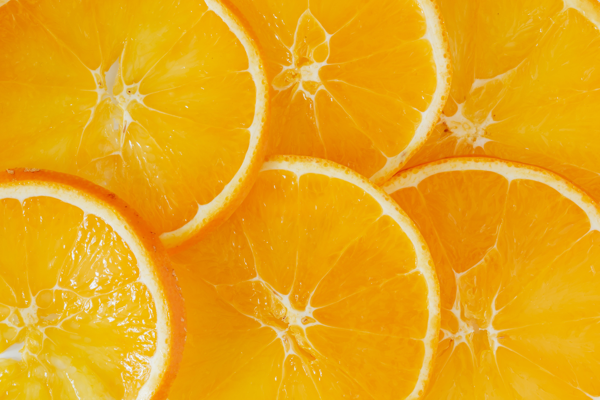

In [ ]:
#@title This is the _input_ image
if INPUT_IMAGE == 'noise':
  input_img = torch.randn(content_img.data.size(), device=device)
elif INPUT_IMAGE == 'content':
  input_img = content_img.clone()
elif INPUT_IMAGE == 'style':
  input_img = style_img.clone()
else:
  image = open_image(INPUT_IMAGE).resize((IMAGE_SIZE, IMAGE_SIZE))
  input_img = image_to_tensor(image)
  input_img += torch.randn(content_img.data.size(), device=device)*0.1

# To visualise it better, instead of clipping values, we rescale
# them to fit [-1,1], and convert to an image. This is mostly because
# the visualization given is closer to what the actual values stored
# in the tensor are.
if INPUT_IMAGE == 'noise':
  img = transforms.ToPILImage()(input_img[0].cpu())
else:
  img = tensor_to_image(input_img[0])
img

We have to choose an optimisation algorithm for our gradient descent.
The algorithm giving the best visual result is LBFGS. But you can try other algorithms like Adam, RAdam, SGD...

In [ ]:
def get_input_optimizer(input_img):
  # This line tell LBFGS what parameters we should optimize
  optimizer = optim.Adam([input_img.requires_grad_()])
  #optimizer = optim.Adam([input_img.requires_grad_()])
  return optimizer

We add one more function in order to display the evolution of the input image while the algorithm run.

In [ ]:
def show_evolution(tensor, history=[], title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = tensor_to_image(image)
    # Display a big figure
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    # Image
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    # Losses
    ax = plt.subplot(122)
    plt.yscale('log')
    plt.title('Losses')
    import numpy as np
    history = np.array(history).T
    plt.plot(history[0], label='Style')
    plt.plot(history[1], label='Content')
    plt.plot(history[2], label='Variation')
    plt.plot(history[3], label='Sum')
    plt.legend(loc="upper right")
    # Finaly show the graph
    plt.show()
    # Display a textual message
    print('Style Loss : {:4f} Content Loss: {:4f} Variation Loss: {:4f} Sum: {:4f}'.format(
        history[0][-1], history[1][-1], history[2][-1], history[3][-1]))

We are now ready to converge toward our AI painted image.

Building the style transfer model..


<ipython-input-114-6a42c7d4d38b>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-114-6a42c7d4d38b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..


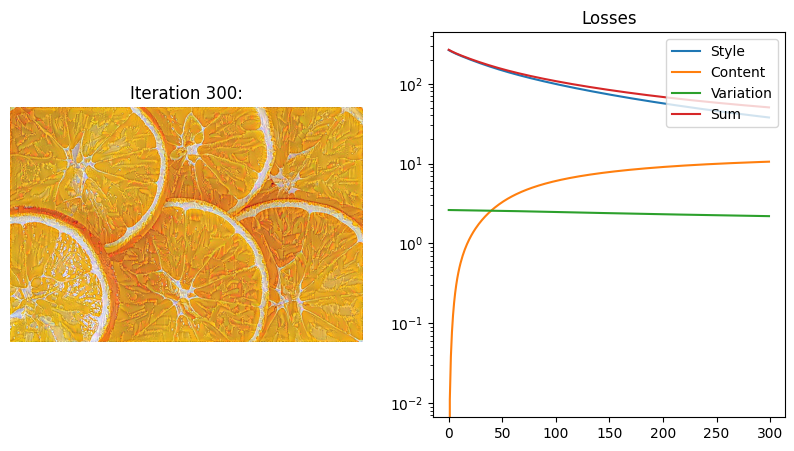

Style Loss : 37.732594 Content Loss: 10.546944 Variation Loss: 2.193202 Sum: 50.472740


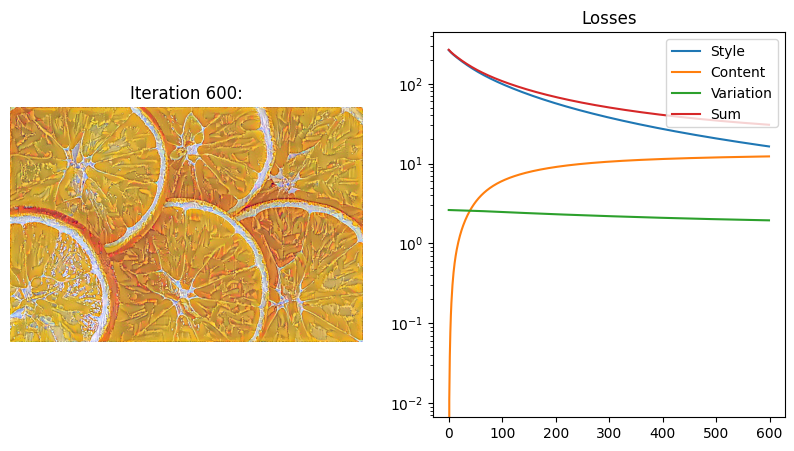

Style Loss : 16.368044 Content Loss: 12.281484 Variation Loss: 1.943282 Sum: 30.592810


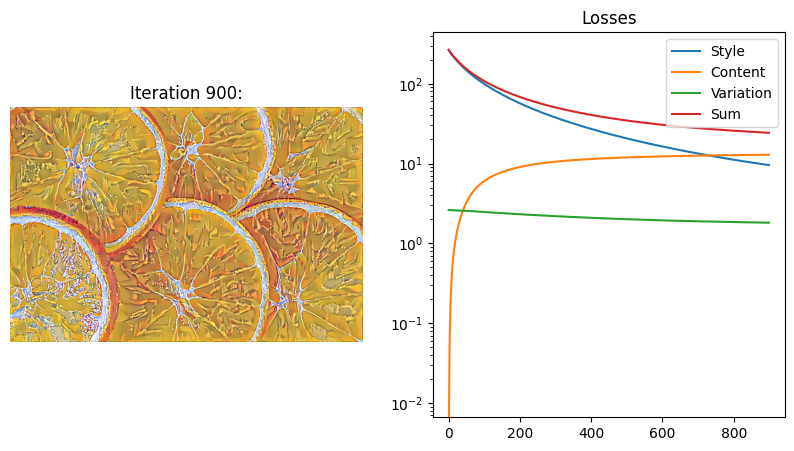

Style Loss : 9.545468 Content Loss: 12.893053 Variation Loss: 1.816932 Sum: 24.255455


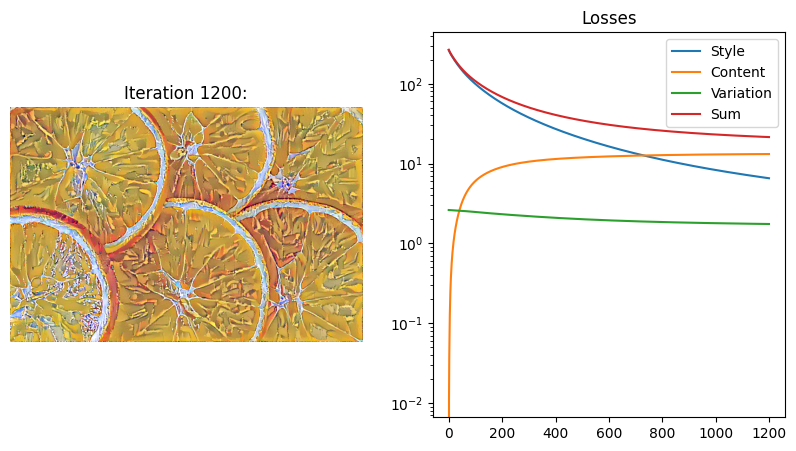

Style Loss : 6.542187 Content Loss: 13.149126 Variation Loss: 1.749304 Sum: 21.440617


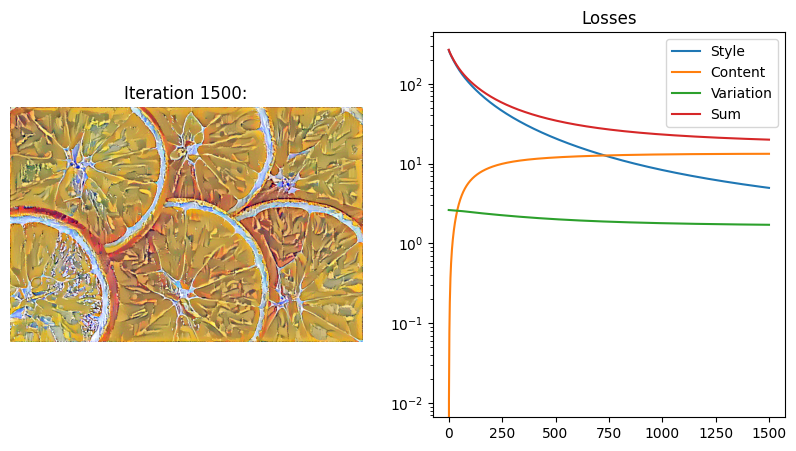

Style Loss : 4.955296 Content Loss: 13.239413 Variation Loss: 1.709836 Sum: 19.904545


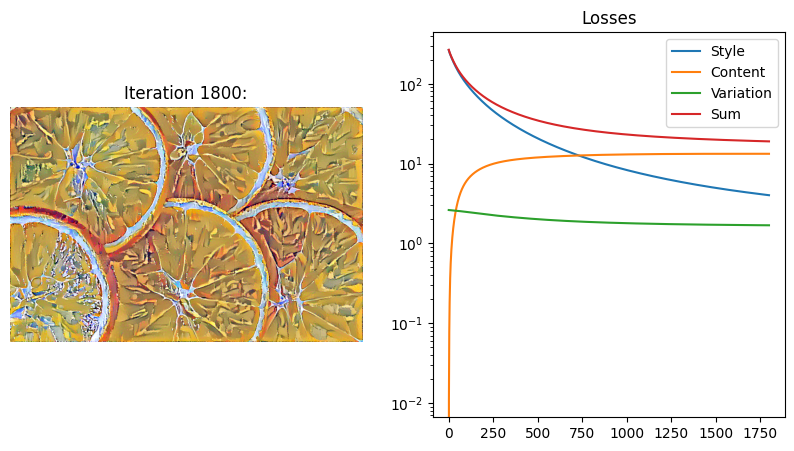

Style Loss : 4.012273 Content Loss: 13.242113 Variation Loss: 1.685211 Sum: 18.939598


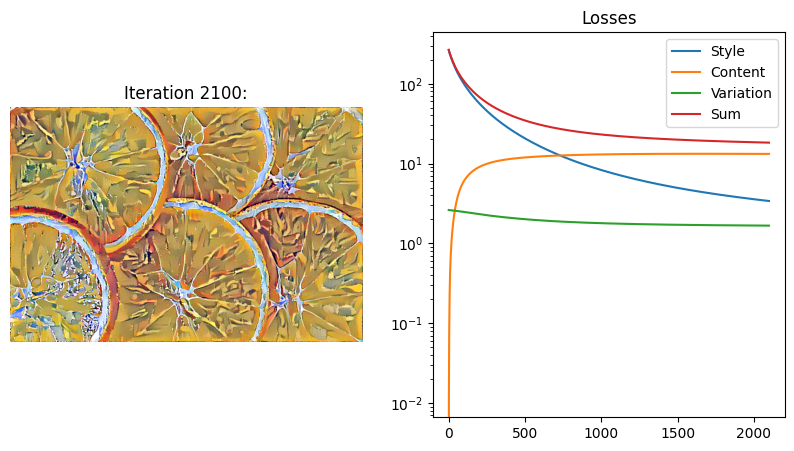

Style Loss : 3.394735 Content Loss: 13.199766 Variation Loss: 1.668519 Sum: 18.263020


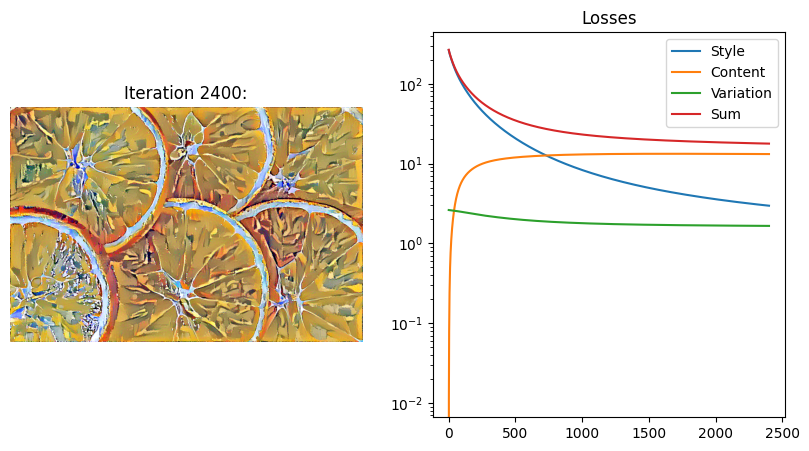

Style Loss : 2.963912 Content Loss: 13.138041 Variation Loss: 1.655495 Sum: 17.757446


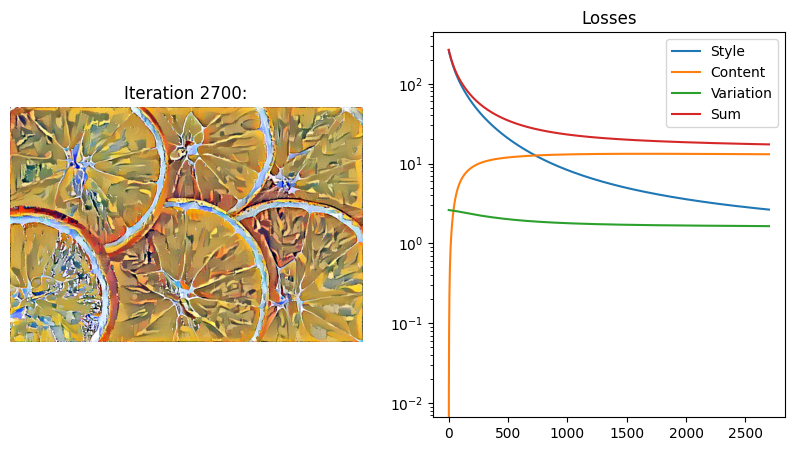

Style Loss : 2.650240 Content Loss: 13.067971 Variation Loss: 1.644181 Sum: 17.362392


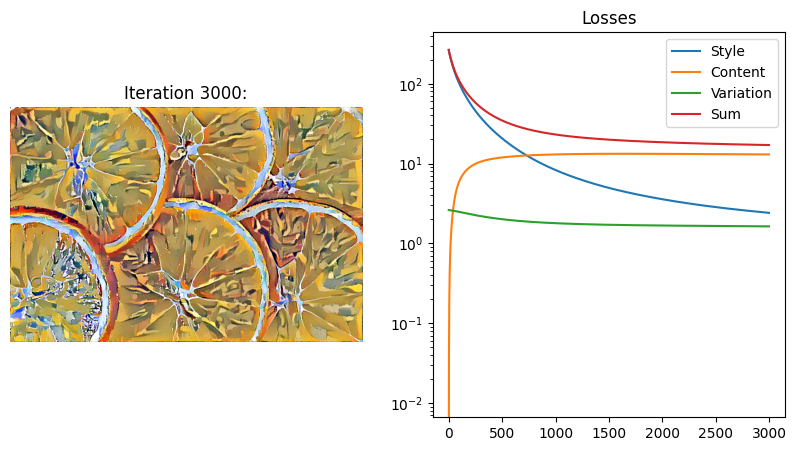

Style Loss : 2.412038 Content Loss: 12.996472 Variation Loss: 1.633236 Sum: 17.041746


In [ ]:
print('Building the style transfer model..')
model, style_losses, content_losses = get_model_and_losses(style_img, content_img)
optimizer = get_input_optimizer(input_img)

print('Optimizing..')
iterations = 0
history=[]
while iterations <= ITERATIONS * 300:
  # Compute the loss and backpropagate to the input_image.
  # (The LBFGS optimizer only accept work through closures.)
  def closure():
      global history
      global iterations

      optimizer.zero_grad()

      # Compute the total variation loss
      variation_score = total_variation_loss(input_img) * TOTAL_VARIATION_WEIGHT
      # Compute the features through the model
      model(input_img)
      # Compute style and content losses
      style_score = sum(sl.loss for sl in style_losses)
      style_score *= STYLE_WEIGHT / len(style_losses)
      content_score = sum(cl.loss for cl in content_losses)
      content_score *= CONTENT_WEIGHT / len(content_losses)
      # Our global loss is the sum of the 3 values
      loss = style_score + content_score + variation_score
      # Save the value of loss in order to draw them as a graph
      history += [[style_score.item(), content_score.item(), variation_score.item(), loss.item()]]

      # If the iteration is a multiple of 100, display some informations
      iterations += 1
      if iterations % 300 == 0:
          show_evolution(input_img.data.clone().detach().clamp(0, 1), history, title="Iteration %d:" % iterations)

      # Backpropagate gradients and leave the optimizer do his job.
      loss.backward()
      return loss

  optimizer.step(closure)



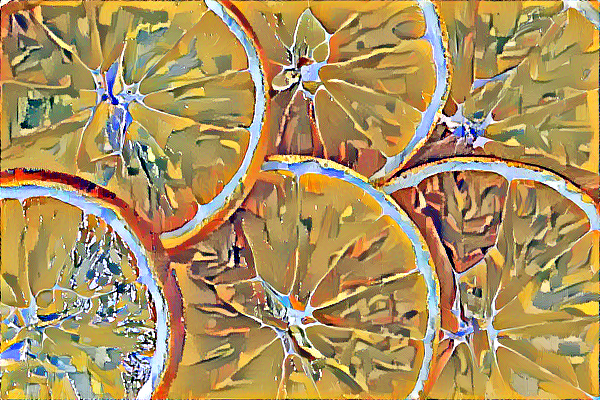

In [ ]:
#@title Our beautiful result
img = tensor_to_image(input_img)
img.save(output_image_path)
img

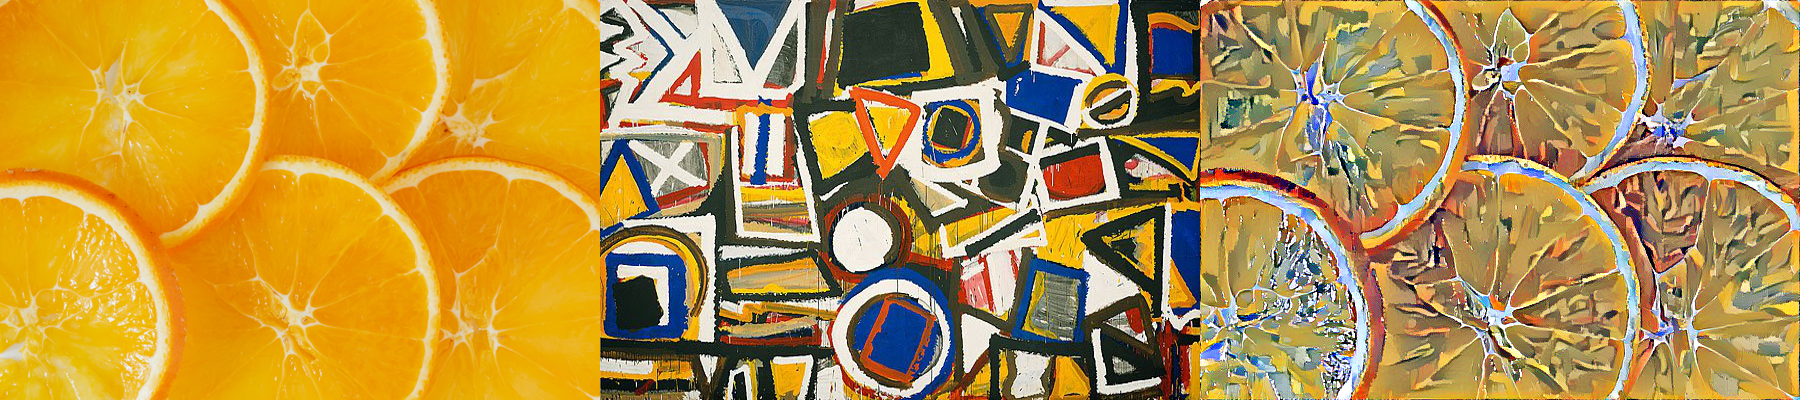

In [ ]:
#@title Visualise combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [content_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined